# EDA for online_retail dataset
#### This notebook provides a high-level overview of the dataset and provides descriptive values and figures about product popularity, etc. It also shifts it to Double-Entry form at the end to make our balance sheet production easier.

#### online_retail was originally an .xlsx file detailing retail invoices from our company. Using the commented code below, this file was converted to a .csv for ease of use. Additional columns 'Month', 'PurchaseTotal', and 'Cancelled' were appended for readability. All transactions were assumed to be done by credit instead of cash.

#### To reconcile the different datasets, timestamps have been shifted up by 11 years to match the Financial/Managerial Accounting datasets

### Import, setup, and load

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [8]:
online_schema = {
    'InvoiceNo': 'string',
    'StockCode': 'string',
    'Quantity': 'int64',
    'UnitPrice' : 'float64',
    'CustomerID' : 'string',
    'Country' : 'string'
}

UK = 'United Kingdom'

In [9]:
online = pd.read_csv('../data/online_retail_sampled.csv', parse_dates=True, dtype=online_schema)
online['InvoiceDate'] = pd.to_datetime(pd.to_datetime(online['InvoiceDate']).dt.date)

### Specifying some handy table projections

In [10]:
online = online.loc[online['InvoiceDate'].dt.year == 2011]
online['PurchaseTotal'] = online['Quantity']*online['UnitPrice']
online['InvoiceDate'] = online['InvoiceDate'] + pd.to_timedelta(52*11, unit='W')
online['Month'] = online['InvoiceDate'].dt.month
condition = online['InvoiceNo'].str.contains('C')
online['Cancelled'] = np.where(condition, 1, 0)
online_noCancels = online.loc[online['Cancelled'] == 0]
online_noReturns = online.loc[((online['Quantity'] < 0) & (online['Cancelled'] == 1)) | (online['Quantity'] > 0)]
online_noReturns_noCancels = online.loc[(online['Quantity'] > 0) & (online['Cancelled'] == 0)]
online_noReturns_noCancels_noUK = online_noReturns_noCancels.loc[online_noReturns_noCancels['Country'] != UK]

### Correlation between quantity purchased vs price per unit

In [11]:
statistic, pvalue = stats.pearsonr(online_noReturns_noCancels['Quantity'],online_noReturns_noCancels['UnitPrice'])
print(statistic, pvalue)

-0.019150494341909262 8.384188751921748e-09


### Correlation between quantity purchased vs price per unit (no UK)

In [87]:
statistic, pvalue = stats.pearsonr(online_noReturns_noCancels_noUK['Quantity'],online_noReturns_noCancels_noUK['UnitPrice'])
print(statistic, pvalue)

-0.02562111371251727 0.02260735907402769


### Is Unit Price a factor in cancellation rates?

In [88]:
prices_cancelled = online_noReturns[online_noReturns['Cancelled'] == 1]['UnitPrice']
prices_fulfilled = online_noReturns[online_noReturns['Cancelled'] == 0]['UnitPrice']
statistic, pvalue = stats.ttest_ind(prices_cancelled, prices_fulfilled, equal_var=False)
print(statistic, pvalue)

3.144079281585209 0.0016975096543650732


### Highest mean quantity per purchase - the item bought in highest quantities (on average) at a time

In [124]:
oNR_MQP = online_noReturns_noCancels[['StockCode','Description','Quantity']]
mqpp = oNR_MQP.groupby(['StockCode','Description']).mean(numeric_only=True)
oNR_MQP.loc[oNR_MQP['Quantity'] == mqpp['Quantity'].max()]

,StockCode,Description,Quantity
94986,21785,RAIN PONCHO,407


### Lowest mean quantity per purchase - the item bought in lowest quantities (on average) at a time

In [92]:
oNR_MQP.loc[oNR_MQP['Quantity'] == mqpp['Quantity'].min()].set_index('StockCode')

,Description,Quantity
StockCode,,
21974,SET OF 36 PAISLEY FLOWER DOILIES,1
35004B,SET OF 3 BLACK FLYING DUCKS,1
21327,SKULLS WRITING SET,1
22824,3 TIER SWEETHEART GARDEN SHELF,1
84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1
...,...,...
90200A,PURPLE SWEETHEART BRACELET,1
C2,CARRIAGE,1
22905,CALENDAR IN SEASON DESIGN,1


### Most popular items in each country
#### (Many of the top items are postage (POST), detailless manual entries (M), or shipping (C2). These are excluded from aggregation)

In [116]:
oNRNC = online_noReturns_noCancels # shorthand alias
oNRNC = oNRNC.loc[~oNRNC['StockCode'].isin(['POST','M','C2','CRUK'])]
oNRNC = oNRNC[['Country','StockCode','Description','Quantity']]
oNRNC.groupby(['Country','StockCode','Description']).sum().reset_index()
maxIndices = oNRNC.groupby('Country')['Quantity'].idxmax()
oNRNC[['Country','StockCode','Description','Quantity']].loc[maxIndices].sort_values('Quantity', ascending=False).reset_index().drop('index', axis=1)

,Country,StockCode,Description,Quantity
0,United Kingdom,22197,SMALL POPCORN HOLDER,4300
1,Australia,21915,RED HARMONICA IN BOX,720
2,Sweden,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,576
3,Japan,21918,SET 12 KIDS COLOUR CHALK STICKS,576
4,EIRE,22197,POPCORN HOLDER,500
5,Germany,23379,PACK OF 12 RED APPLE TISSUES,432
6,Netherlands,22152,PLACE SETTING WHITE STAR,432
7,Channel Islands,21785,RAIN PONCHO,407
8,France,23203,JUMBO BAG VINTAGE DOILY,300
9,Spain,84997C,CHILDRENS CUTLERY POLKADOT BLUE,288


### Did some countries cancel more than others?

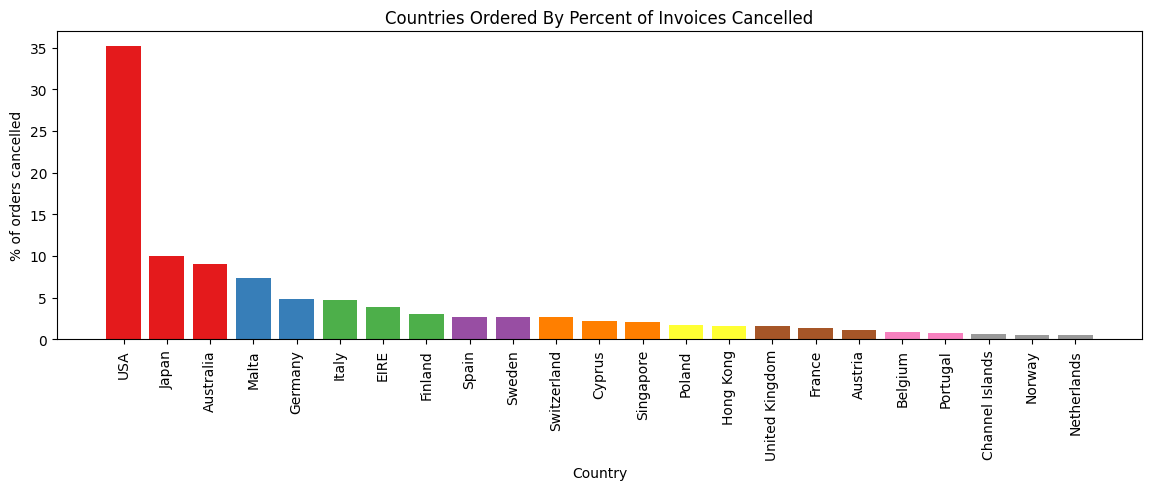

In [6]:
perCountry_All = online_noReturns.groupby('Country').agg(Count=('InvoiceNo', 'count')).reset_index()
perCountry_Cancelled = online_noReturns.loc[online_noReturns['Cancelled'] == 1].groupby(['Country', 'Cancelled']).agg(Count=('InvoiceNo', 'count')).reset_index()

joined = perCountry_All.merge(perCountry_Cancelled[['Country','Count']], on='Country', suffixes=('_All','_Cancelled'))
joined['Ratio'] = 100*joined['Count_Cancelled']/joined['Count_All']
joined = joined.sort_values('Ratio', ascending=False)
plt.figure(figsize=(14,4))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('% of orders cancelled')
color_range = np.linspace(0,1,len(joined))
plt.title('Countries Ordered By Percent of Invoices Cancelled')
plt.bar(joined['Country'],joined['Ratio'], color=plt.cm.Set1(color_range))
plt.show()

In [18]:
cancelled_USA = online_noReturns[(online_noReturns['Country'] == 'USA')]
cancelled_USA.sort_values('StockCode')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PurchaseTotal,Month,Cancelled
3499,580553,20674,GREEN POLKADOT BOWL,16,2022-11-21,1.25,12646.0,USA,20.00,12,0
35822,580553,20676,RED RETROSPOT BOWL,16,2022-11-21,1.25,12646.0,USA,20.00,12,0
65412,580553,20677,PINK POLKADOT BOWL,16,2022-11-21,1.25,12646.0,USA,20.00,12,0
87216,570467,21059,PARTY INVITES DINOSAURS,12,2022-09-26,0.85,12607.0,USA,10.20,10,0
15844,550644,21067,VINTAGE RED TEATIME MUG,6,2022-04-05,1.25,12733.0,USA,7.50,4,0
45172,570467,21122,SET/10 PINK POLKADOT PARTY CANDLES,24,2022-09-26,1.25,12607.0,USA,30.00,10,0
4743,C570867,21124,SET/10 BLUE POLKADOT PARTY CANDLES,-24,2022-09-28,1.25,12607.0,USA,-30.00,10,1
43691,570467,21210,SET OF 72 RETROSPOT PAPER DOILIES,12,2022-09-26,1.45,12607.0,USA,17.40,10,0
62841,570467,21498,RED RETROSPOT WRAP,25,2022-09-26,0.42,12607.0,USA,10.50,10,0
71730,C570867,21499,BLUE POLKADOT WRAP,-25,2022-09-28,0.42,12607.0,USA,-10.50,10,1


### Did some countries return more than others?

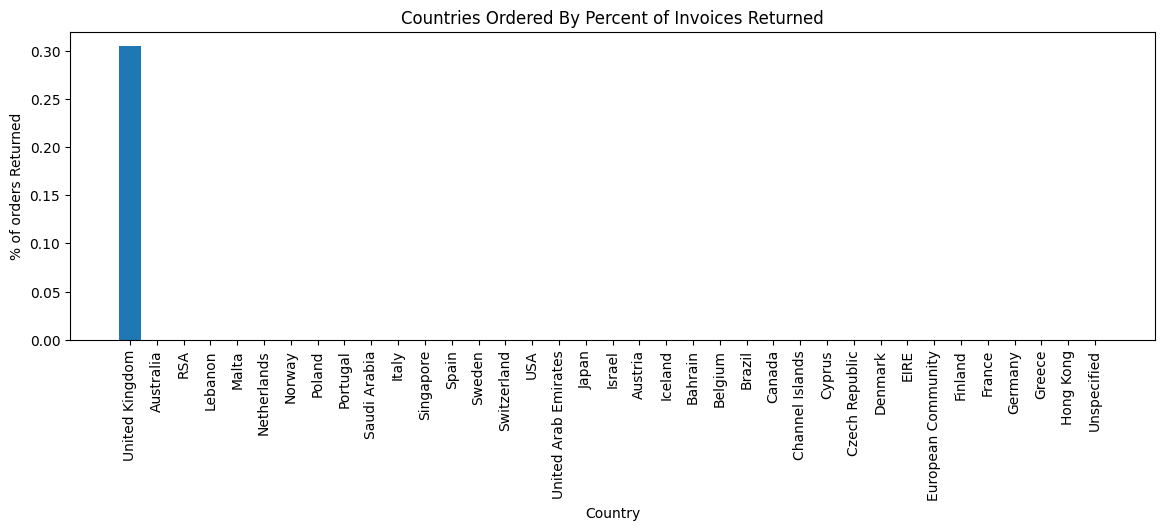

In [24]:
perCountry_All = online_noCancels.groupby('Country').agg(Count=('InvoiceNo', 'count')).reset_index()
perCountry_Returned = online_noCancels.loc[online['Quantity'] < 0].groupby(['Country']).agg(Count=('InvoiceNo', 'count')).reset_index()

perCountry_Returned
joined = perCountry_All.merge(perCountry_Returned[['Country','Count']], on='Country', how='left', suffixes=('_All','_Returned')).fillna(0) 
joined['Ratio'] = 100*joined['Count_Returned']/joined['Count_All']
joined = joined.sort_values('Ratio', ascending=False)
plt.figure(figsize=(14,4))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('% of orders Returned')
plt.title('Countries Ordered By Percent of Invoices Returned')
plt.bar(joined['Country'],joined['Ratio'])
plt.show()

#### I am willing to bet that returns are only accepted domestically.

### Trend: Net income over time - aggregated by month - 2022 (the only complete year)

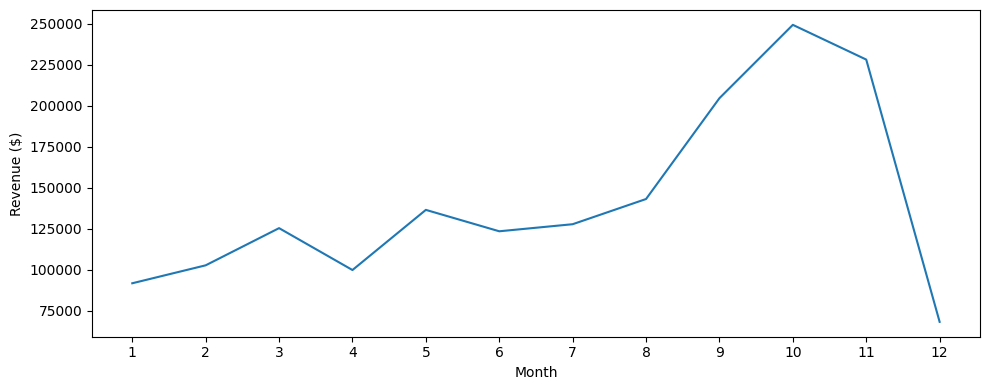

In [65]:
onlineAgg_perMonth = online[['InvoiceDate','Quantity','PurchaseTotal','Month']] \
    .groupby(['Month']).sum(numeric_only=True).reset_index()
plt.figure(figsize=(10,4))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.plot(onlineAgg_perMonth['Month'],onlineAgg_perMonth['PurchaseTotal'])
plt.tight_layout()